In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Question 1) 
pcc_train = pd.read_csv('PCC_study_train.csv')
pcc_train = pcc_train.drop(columns='Unnamed: 0')

In [4]:
table = pcc_train.groupby(by='vax_status').value_counts()
table

vax_status    WBscore    PCCsymp
Unvaccinated  Unchanged  Same       11
              Worsened   More        6
                         Same        6
              Unchanged  Less        5
                         More        4
              Improved   Less        3
                         Same        3
                         More        1
Vaccinated    Improved   Less       27
              Unchanged  Less        3
              Improved   Same        1
              Unchanged  More        1
                         Same        1
              Worsened   Less        1
                         More        1
                         Same        1
Name: count, dtype: int64

In [5]:
#a) p(improved&less|vaccinated) 36 vaccinated, reading table above, 
#the number that improved and has fewer symptoms is 27. 
p_a = 27/36
p_a

0.75

In [6]:
#b) p(improved&less|unvaccinated) 39 unvaccinated
#improved and less for unvaccinated is 3 
p_b = 3/39
p_b

0.07692307692307693

In [7]:
#c
pcc_train_melted = pcc_train.melt(id_vars='vax_status', 
                                        var_name='symptom_type', 
                                        value_name='symptom_value')

pcc_train_pivot = pcc_train_melted.pivot_table(
    index=['symptom_type', 'symptom_value'],
    columns='vax_status',
    aggfunc='size',
    fill_value=0
).div([39, 36], axis=1)
pcc_train_pivot

vax_status                  Unvaccinated  Vaccinated
symptom_type symptom_value                          
PCCsymp      Less               0.205128    0.861111
             More               0.282051    0.055556
             Same               0.512821    0.083333
WBscore      Improved           0.179487    0.777778
             Unchanged          0.512821    0.138889
             Worsened           0.307692    0.083333

In [8]:
def vax_status_prob(WBscore,PCCsymp):
    test_case = [WBscore,PCCsymp]
    f_y, f_n = 0.48, 0.52
    for i, symptom_name in enumerate(pcc_train.columns[1:]):
        f_y *= pcc_train_pivot['Vaccinated'][symptom_name][test_case[i]] 
        f_n *= pcc_train_pivot['Unvaccinated'][symptom_name][test_case[i]]
        # normalize the probabilities (marginalization)
    p_y = f_y / (f_y + f_n)
    p_n = f_n / (f_y + f_n)
    print('P(Vax_status = Vaccinated | symptoms) = %.3f'%(p_y))
    if p_y > p_n:
        print('Prediction: Vaccinated')  
    else:
        print('Prediction: Unvaccinated') 

In [9]:
#e)
vax_status_prob('Improved','Same')

P(Vax_status = Vaccinated | symptoms) = 0.394
Prediction: Unvaccinated


In [10]:
#f) 
def vax_class(WBscore,PCCsymp):
    test_case = [WBscore,PCCsymp]
    f_y, f_n = 0.48, 0.52
    for i, symptom_name in enumerate(pcc_train.columns[1:]):
        f_y *= pcc_train_pivot['Vaccinated'][symptom_name][test_case[i]] 
        f_n *= pcc_train_pivot['Unvaccinated'][symptom_name][test_case[i]]
        # normalize the probabilities (marginalization)
    p_y = f_y / (f_y + f_n)
    p_n = f_n / (f_y + f_n)
    if p_y > p_n:
        return 'Vaccinated' 
    else:
        return 'Unvaccinated'
pcc_study = pd.read_csv('PCC_study_test.csv').drop(columns='Unnamed: 0')

In [11]:
pcc_study['prediction'] = pcc_study.apply(lambda row: vax_class(row['WBscore'], row['PCCsymp']), axis=1)

In [12]:
#convert values to integers first:
to_int_dict = {'Worsened': 0, 'Unchanged': 1, 'Improved': 2, 'Less': 0, 'Same': 1, 'More': 2, 
               'Unvaccinated': 0, 'Vaccinated': 1}
int_pcc_train = pcc_train.applymap(lambda x: to_int_dict[x])
int_pcc_test = pcc_study.applymap(lambda x: to_int_dict[x])

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB

###############################################
# Split data to training and testing datasets #
###############################################
X_train = int_pcc_train.iloc[:,1:3]
X_test = int_pcc_test.iloc[:,1:3]
y_train = int_pcc_train.iloc[:,0]

##############################################
# Initialize an instance of the model object #
##############################################
model = CategoricalNB()

##########################################
# Train the model / fit model parameters #
##########################################
model.fit(X_train, y_train)

##################
# Test the model #
##################

print('Testing datapoint: ', X_test, 'Model prediction: ', model.predict(X_test), '\n')

Testing datapoint:      WBscore  PCCsymp
0         2        0
1         2        0
2         2        0
3         0        0
4         1        0
5         2        0
6         2        0
7         2        0
8         1        2
9         2        0
10        2        0
11        2        0
12        2        0
13        2        0
14        1        0
15        2        0
16        2        0
17        2        0
18        2        0
19        2        0
20        2        0
21        1        0
22        2        0
23        0        1
24        2        0
25        2        0
26        2        0
27        2        1
28        2        2
29        2        0
30        0        2
31        2        0
32        1        1
33        1        0
34        0        2
35        1        1
36        1        1
37        2        1
38        1        0
39        1        0
40        2        1
41        0        2
42        0        0
43        1        1
44        2        1
45        1   

In [14]:
prediction = model.predict(X_test)
int_pcc_test['Classifier Prediction'] = prediction

In [15]:
assert (int_pcc_test['prediction'] == int_pcc_test['Classifier Prediction']).all()
#the cell runs so this must be true 

In [16]:
#Question 2) 
iris = pd.read_csv('iris.csv')
iris = iris.drop(columns='rownames')
iris_train = iris.sample(n=105,replace=False)
iris_test = iris.drop(iris_train.index).reset_index()
iris_test = iris.drop(iris_train.index)
new_row = [6.56,3.18,4.31,1.32,'flower']
iris_test.loc[len(iris_test)] = new_row 
iris_test = iris_test.reset_index()

In [17]:
setosa = iris_train[iris_train['Species']=='setosa']
versicolor = iris_train[iris_train['Species']=='versicolor']
virginica = iris_train[iris_train['Species']=='virginica']

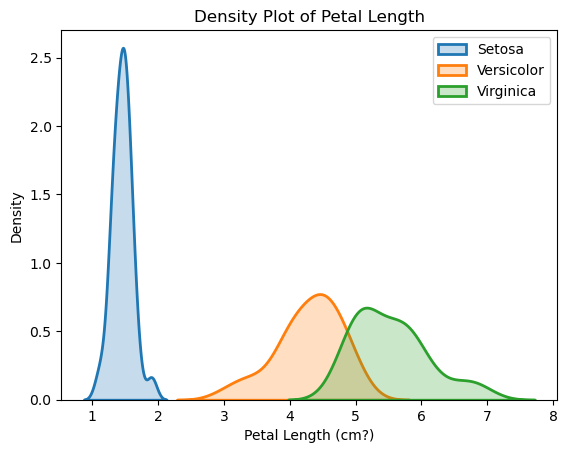

In [47]:
#b) 
sns.kdeplot(setosa['Petal.Length'],fill='True',linewidth=2,label='Setosa')
sns.kdeplot(versicolor['Petal.Length'],fill='True',linewidth=2,label='Versicolor')
sns.kdeplot(virginica['Petal.Length'],fill='True',linewidth=2,label='Virginica')
plt.title('Density Plot of Petal Length')
plt.xlabel('Petal Length (cm?)')
plt.ylabel('Density')
plt.legend()

The distributions of petal length are all unimodal, with peaks around 1.5, 4.3, and 5.5 respectively. Setosa's distribution is less varied than that of Versicolor and Virginica, which is why its density peak is so much higher. Setosa's distribution does not overlap with the other two, making petal length a good predictor for determining if a flower is Setosa or not. Versicolor's distribution is left-skewed, whereas Virginica's is right-skewed. Setosa is relatively centered. 

In [19]:
#c) 
iris_train.groupby(by='Species')['Petal.Length'].mean()

Species
setosa        1.451515
versicolor    4.284211
virginica     5.532353
Name: Petal.Length, dtype: float64

In [20]:
iris_train.groupby(by='Species')['Petal.Length'].std()

Species
setosa        0.152318
versicolor    0.492937
virginica     0.555807
Name: Petal.Length, dtype: float64

d) Given an iris wth petal length 4.31, I would classify it as versicolor as the mean of its distribution is 4.28, which is very close to 4.31. 4.31 is not in the distribution of setosa, and is more than 2 standard deviations away from the mean length of virginica, which means the probability that it is versicolor is the highest. 

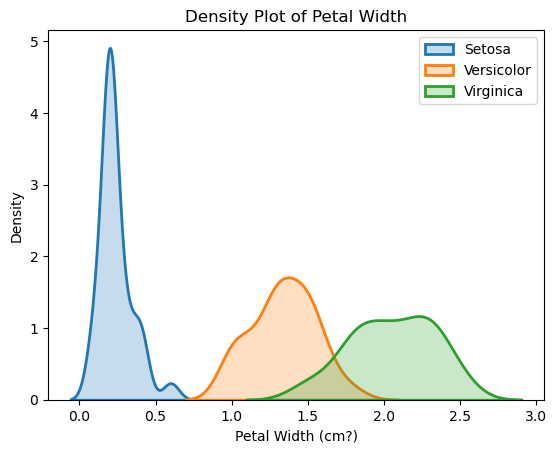

In [48]:
#e) more density plots! 
#petal width
sns.kdeplot(setosa['Petal.Width'],fill='True',linewidth=2,label='Setosa')
sns.kdeplot(versicolor['Petal.Width'],fill='True',linewidth=2,label='Versicolor')
sns.kdeplot(virginica['Petal.Width'],fill='True',linewidth=2,label='Virginica')
plt.title('Density Plot of Petal Width')
plt.xlabel('Petal Width (cm?)')
plt.ylabel('Density')
plt.legend()

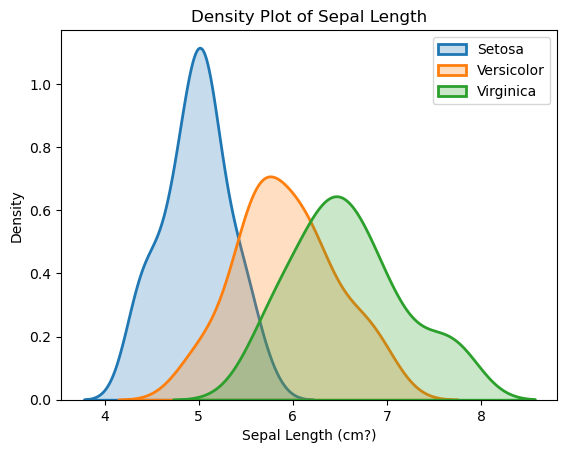

In [49]:
#sepal length
sns.kdeplot(setosa['Sepal.Length'],fill='True',linewidth=2,label='Setosa')
sns.kdeplot(versicolor['Sepal.Length'],fill='True',linewidth=2,label='Versicolor')
sns.kdeplot(virginica['Sepal.Length'],fill='True',linewidth=2,label='Virginica')
plt.title('Density Plot of Sepal Length')
plt.xlabel('Sepal Length (cm?)')
plt.ylabel('Density')
plt.legend()

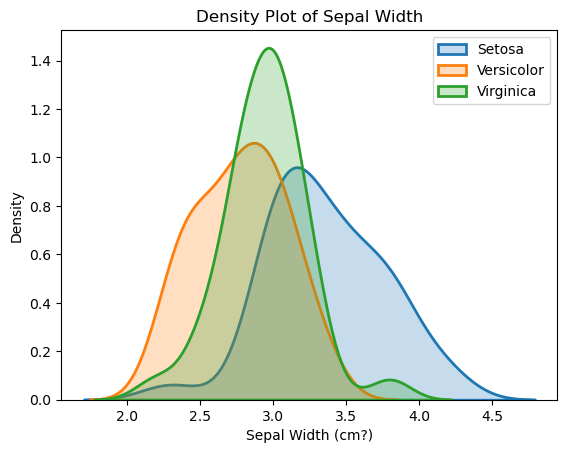

In [52]:
#sepal width
sns.kdeplot(setosa['Sepal.Width'],fill='True',linewidth=2,label='Setosa')
sns.kdeplot(versicolor['Sepal.Width'],fill='True',linewidth=2,label='Versicolor')
sns.kdeplot(virginica['Sepal.Width'],fill='True',linewidth=2,label='Virginica')
plt.title('Density Plot of Sepal Width')
plt.xlabel('Sepal Width (cm?)')
plt.ylabel('Density')
plt.legend()

In [24]:
#f) Guassian Naive Bayes Classifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB # <--- the model is implemented here

###############################################
# Split data to training and testing datasets #
###############################################
X_train = iris_train.iloc[:,0:4]
X_test = iris_test.iloc[:,1:5]
y_train = iris_train.iloc[:,4]

##############################################
# Initialize an instance of the model object #
##############################################
model = GaussianNB()

##########################################
# Train the model / fit model parameters #
##########################################
model.fit(X_train, y_train)

##################
# Test the model #
##################

print('Testing datapoint: ', X_test.iloc[[-1]], 'Model prediction: ', model.predict(X_test.iloc[[-1]]), '\n')
#last row is the data point we want. 

Testing datapoint:      Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
45          6.56         3.18          4.31         1.32 Model prediction:  ['versicolor'] 



My classifier predicted the datapoint as versicolor. 

In [25]:
#Question 3) 
print('Testing datapoint: ', X_test, 'Model prediction: ', model.predict(X_test), '\n')

Testing datapoint:      Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
0           4.60         3.10          1.50         0.20
1           5.00         3.60          1.40         0.20
2           5.40         3.90          1.70         0.40
3           4.60         3.40          1.40         0.30
4           4.80         3.40          1.60         0.20
5           5.80         4.00          1.20         0.20
6           5.70         4.40          1.50         0.40
7           5.10         3.50          1.40         0.30
8           5.40         3.40          1.70         0.20
9           4.60         3.60          1.00         0.20
10          5.10         3.30          1.70         0.50
11          4.80         3.40          1.90         0.20
12          5.00         3.40          1.60         0.40
13          5.20         3.40          1.40         0.20
14          4.90         3.60          1.40         0.10
15          5.00         3.50          1.30         0.30
16         

In [26]:
predicted_labels = model.predict(X_test[:-1])#not including the one from q2 cuz we don't know what flower it is
actual_labels = iris_test['Species'][:-1]

In [27]:
#c) and d) 
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Compute the confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, columns=sorted(set(actual_labels)), index=sorted(set(actual_labels)))
conf_matrix_df

,setosa,versicolor,virginica
setosa,17,0,0
versicolor,0,12,0
virginica,0,2,14


The accuracy of my classifier is 43/45 = 95.56%. The most common error in my code is incorrectly predicting virginica flowers as versicolor flowers, with 2/16 virginica flowers being predicted as versicolor. This is a type 1 error (false positive) with regards to virginica. 

In [28]:
#Question 4) 
#a)
spam = pd.read_csv('spam.csv',encoding='latin1')
spam = spam.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])
spam = spam.rename(columns={'v1':'Label','v2':'Text'})
print(spam.shape)
spam
#5572 rows and 2 columns

(5572, 2)


,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [29]:
spam['Text'] = spam['Text'].apply(lambda x: x.replace('.',' ').replace(',', ' '))
spam['Text'] = spam['Text'].apply(lambda x: x.replace(':',' ').replace(';', ' '))
spam['Text'] = spam['Text'].apply(lambda x: x.replace('?',' ').replace('!', ' ')) 
spam['Text'] = spam['Text'].apply(lambda x: x.replace('(',' ').replace(')', ' '))
spam['Text'] = spam['Text'].apply(lambda x: x.replace('"',' ').replace('/', ' '))
spam['Text'] = spam['Text'].apply(lambda x: x.lower())

In [30]:
spam_df = spam[spam['Label']=='spam']
ham_df = spam[spam['Label']=='ham']

In [31]:
#b) ham has 4825 rows and spam has 747 rows
len(ham_df),len(spam_df)

(4825, 747)

In [32]:
#c) 
ham_df['Text']

0       go until jurong point  crazy   available only ...
1                           ok lar    joking wif u oni   
3       u dun say so early hor    u c already then say   
4       nah i don't think he goes to usf  he lives aro...
6       even my brother is not like to speak with me  ...
                              ...                        
5565                                         huh y lei   
5568                will ì_ b going to esplanade fr home 
5569    pity  * was in mood for that  so   any other s...
5570    the guy did some bitching but i acted like i'd...
5571                           rofl  its true to its name
Name: Text, Length: 4825, dtype: object

In [33]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joycezhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [54]:
spam_tok = nltk.word_tokenize(spam_df['Text'].astype(str).str.cat(sep = ' '))
ham_tok = nltk.word_tokenize(ham_df['Text'].astype(str).str.cat(sep = ' '))

In [35]:
#d) 
from nltk.probability import FreqDist
spam_freq_dist = nltk.FreqDist(spam_tok) 
ham_freq_dist = nltk.FreqDist(ham_tok) 

In [36]:
#e
prob_sorry_ham = ham_freq_dist['sorry']/sum(ham_freq_dist.values())
prob_sorry_spam = spam_freq_dist['sorry']/sum(spam_freq_dist.values())
print(prob_sorry_ham)
print(prob_sorry_spam)

0.0021569603451136554
0.00015603869759700406


In [37]:
#f) 
import string
def message_prob(message, frequency_dict):
    message = message.translate(str.maketrans('', '', string.punctuation)).lower()
    message_tokens = nltk.word_tokenize(message)
    message_freq_dist = FreqDist(message_tokens)
    probability = 1.0
    for word in message_freq_dist.keys():
        # Use Laplace smoothing to handle unseen words, adds one to number so probability is not 0 
        prob_word = (frequency_dict[word] + 1) / (sum(frequency_dict.values()) + len(frequency_dict))
        probability *= prob_word
    return probability

In [38]:
#g)
message = 'Sorry my roommates took forever, it ok if I come by now?'
message_prob(message,ham_freq_dist)

2.9393363482641084e-33

In [39]:
message_prob(message,spam_freq_dist)

3.0555605796651576e-41

In [40]:
#h)
from math import log
def message_log_prob(message,frequency_dict):
    message = message.translate(str.maketrans('', '', string.punctuation)).lower()
    message_tokens = nltk.word_tokenize(message)
    message_freq_dist = FreqDist(message_tokens)
    probability = 1.0
    for word in message_freq_dist.keys():
        # Use Laplace smoothing to handle unseen words, adds one to number so probability is not 0 
        prob_word = (frequency_dict[word] + 1) / (sum(frequency_dict.values()) + len(frequency_dict))
        probability += np.log(prob_word)
    return probability

In [41]:
message_log_prob(message,ham_freq_dist)

-73.90712424481715

In [42]:
message_log_prob(message,spam_freq_dist)

-92.28902574116687

In [43]:
#i) 
def log_scores(message):
    ham = message_log_prob(message,ham_freq_dist)
    spam = message_log_prob(message,spam_freq_dist)
    return ham-spam

#j)
log_scores(message)

18.381901496349712

In [44]:
#k) 
spam['token length'] = spam['Text'].apply(lambda x: len(nltk.word_tokenize(x)))
spam_75 = spam.loc[spam['token length']<=75]
spam_75['scores'] = spam_75['Text'].apply(lambda x: log_scores(x))

/var/folders/vx/48tpbqt12v19v214cg_b117h0000gn/T/ipykernel_5266/3330593803.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_75['scores'] = spam_75['Text'].apply(lambda x: log_scores(x))


In [45]:
ham_scores = spam_75.loc[spam_75['Label']=='ham']['scores']
spam_scores = spam_75.loc[spam_75['Label']=='spam']['scores']
ham_scores.median(),spam_scores.median(),ham_scores.min(),spam_scores.min(),ham_scores.max(),spam_scores.max()
#used stats to discuss distribution below

(9.19052674801474,
 -39.43262355951413,
 -11.474071425468026,
 -79.2043014425384,
 62.038955831798546,
 14.51320681964637)

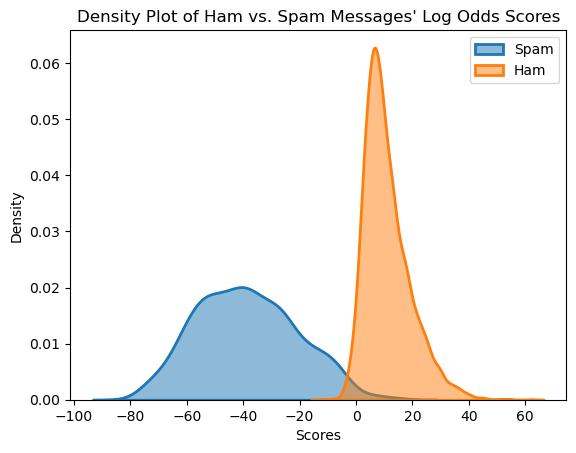

In [53]:
import seaborn as sns
sns.kdeplot(spam_scores,alpha=0.5,fill='True',linewidth=2,label='Spam')
sns.kdeplot(ham_scores,alpha=0.5,fill='True',linewidth=2,label='Ham')
plt.title("Density Plot of Ham vs. Spam Messages' Log Odds Scores")
plt.xlabel('Scores')
plt.ylabel('Density')
plt.legend()

Ham scores have a much narrower distribution (-11.5,62.0) than spam scores (-79.2,14.51). The distribution for ham is centered around 10, whereas spam scores has a center around -40. This means that the distribution of ham scores has a lower variation than that of the distribution of spam scores. This is good evidence to suppor that the distribution of log odds scores between ham and spam messages are different, although the distributions overlap slightly between -11 and 15. 

In [55]:
conda install nbconvert

Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.9.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
